In [27]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
import numpy as np
from PIL import Image
from config import DEVICE
from torch import nn
import math
import config
from dataset import CustomImageDataset
from torch.utils.data import DataLoader
from UNet import *
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

transform = config.transform
reverse_transform = config.reverse_transform

In [2]:
class Diffusion:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        
        """
        if 
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]
            
        
        """ 
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)
            
        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        
        return mean + variance, noise.to(device)
    
    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if 
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3
            
        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)
        
        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [21]:
IMAGE_SHAPE = (32, 32)


NameError: name 'config' is not defined

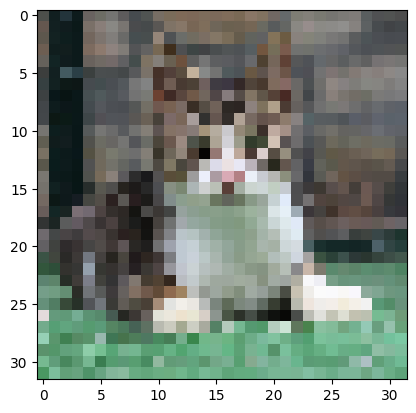

In [11]:
cat = Image.open("cat.jpg")
cat_tensor = transform(cat)
plt.imshow(reverse_transform(cat_tensor))

<Figure size 1500x1500 with 0 Axes>

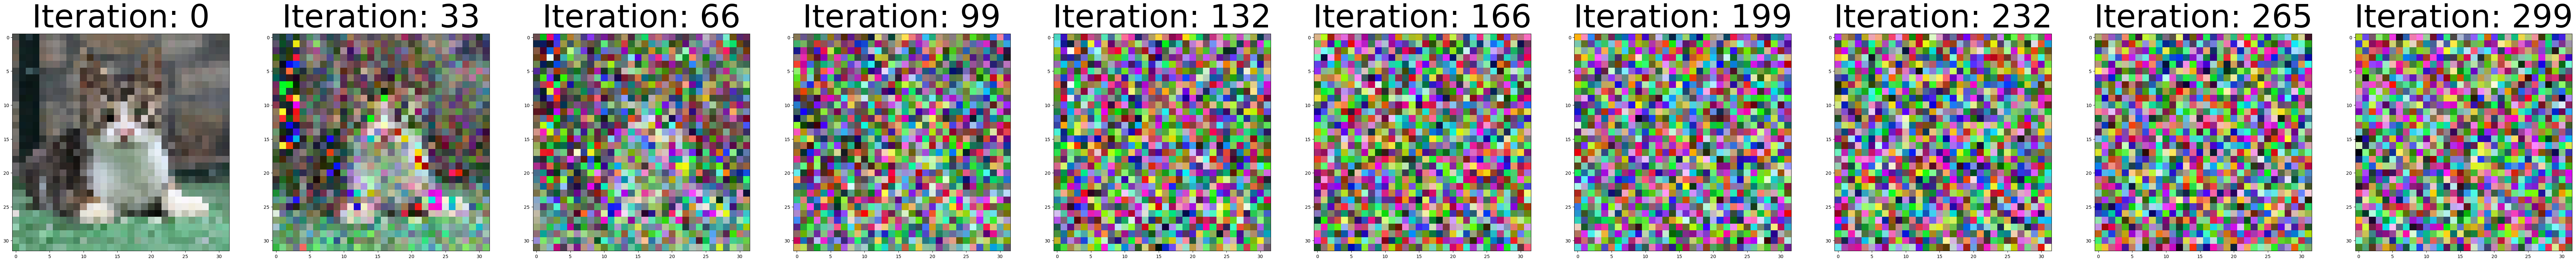

In [13]:
diffusion = Diffusion()

NO_DISPLAY_IMAGES = 10
torch_image_batch = torch.stack([cat_tensor] * NO_DISPLAY_IMAGES)
t = torch.linspace(0, diffusion.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion.forward(torch_image_batch, t, DEVICE)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize = (100,100))

for idx, image in enumerate(noisy_image_batch):
    ax[idx].imshow(reverse_transform(image))
    ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 70)
plt.show()

In [28]:
NO_EPOCHS = 2000
PRINT_FREQUENCY = 400
LR = 0.001
BATCH_SIZE = 128
VERBOSE = True

unet = UNet(labels=False)
unet.to(DEVICE)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [17]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()


In [18]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [ ]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    
    batch = torch.stack([cat_tensor] * BATCH_SIZE)
    t = torch.randint(0, diffusion.timesteps, (BATCH_SIZE,)).long().to(DEVICE)

    batch_noisy, noise = diffusion.forward_pass(batch, t) 
    predicted_noise = unet(batch_noisy, t)
    
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)

In [24]:
from torch.utils.data import Dataset, DataLoader
import os
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, fname) 
                            for fname in os.listdir(image_dir) 
                            if fname.endswith(('.png', '.jpg', '.jpeg'))]
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Ensure 3 channels (RGB)
        if self.transform:
            image = self.transform(image)
        return image, -1

In [29]:
train_ds = CustomImageDataset(image_dir="Dataset/Train", transform=transform)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = CustomImageDataset(image_dir="Dataset/Test", transform=transform)
test_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)


In [25]:
from tqdm import tqdm

PRINT_FREQUENCY = 1
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    loop = tqdm(train_dl, total = len(train_dl))
    for batch, _, _ in loop:
        t = torch.randint(0, diffusion.timesteps, (BATCH_SIZE,)).long().to(DEVICE)
        batch = batch.to(DEVICE)
        batch_noisy, noise = diffusion.forward(batch, t, DEVICE) 
        predicted_noise = unet(batch_noisy, t)

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
        loop.set_description(f"Epoch: {epoch} | Train Loss {loss.item()}")
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    
    for batch, _, _ in test_dl:
        with torch.no_grad():
            t = torch.randint(0, diffusion.timesteps, (BATCH_SIZE,)).long().to(DEVICE)
            batch = batch.to(DEVICE)

            batch_noisy, noise = diffusion.forward(batch, t, DEVICE) 
            predicted_noise = unet(batch_noisy, t)

            loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
            mean_epoch_loss_val.append(loss.item())

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)
                
        torch.save(unet.state_dict(), f"epoch: {epoch}")

ModuleNotFoundError: No module named 'tqmd'